In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import plotly.graph_objects as go
url = "./data_labels_mainData.csv"
lm = pd.read_csv(url, header=0, sep=",")
url = "./data_labels_extraData.csv"
le = pd.read_csv(url, header = 0, sep = ",")

#c/download/mlass2
#im guessing all images are 27x27

"""#might have to run the following lines if wanting to use gpu
export PATH="${PATH}:/usr/local/nvidia/bin:/usr/local/cuda/bin"
CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:$CUDNN_PATH/lib
export PATH="${PATH}:/usr/local/nvidia/bin:/usr/local/cuda/bin"

symbiotic links
"""
"""
cd /usr/lib/wsl/lib/
sudo cp libcuda.so.1 libcuda.so.1.backup
sudo cp libcuda.so libcuda.so.backup
sudo rm libcuda.so.1
sudo rm libcuda.so
sudo ln -s libcuda.so.1.1 libcuda.so.1
sudo ln -s libcuda.so.1.1 libcuda.so
sudo ldconfig
"""

2023-05-16 18:32:16.488033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 18:32:17.091971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'\ncd /usr/lib/wsl/lib/\nsudo cp libcuda.so.1 libcuda.so.1.backup\nsudo cp libcuda.so libcuda.so.backup\nsudo rm libcuda.so.1\nsudo rm libcuda.so\nsudo ln -s libcuda.so.1.1 libcuda.so.1\nsudo ln -s libcuda.so.1.1 libcuda.so\nsudo ldconfig\n'

In [2]:
lm.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [3]:
lm.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [4]:
lm.value_counts()

InstanceID  patientID  ImageName  cellTypeName  cellType  isCancerous
1           36         1.png      fibroblast    0         0              1
13760       54         13760.png  others        3         0              1
13753       54         13753.png  others        3         0              1
13754       54         13754.png  others        3         0              1
13755       54         13755.png  others        3         0              1
                                                                        ..
5480        50         5480.png   fibroblast    0         0              1
5481        50         5481.png   fibroblast    0         0              1
5482        50         5482.png   fibroblast    0         0              1
5483        50         5483.png   fibroblast    0         0              1
22444       27         22444.png  others        3         0              1
Length: 9896, dtype: int64

In [5]:
print(lm.groupby("cellTypeName").sum())

              InstanceID  patientID  cellType  isCancerous
cellTypeName                                              
epithelial      27445916     121296      8158         4079
fibroblast      24541213      55725         0            0
inflammatory    31935645      69164      2543            0
others          16955864      48340      4158            0


/tmp/ipykernel_27950/2613561896.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(lm.groupby("cellTypeName").sum())


In [6]:
from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(lm, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(lm, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 7422, Val Data: 2474, Test Data: 1980


In [7]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.12.0'

In [2]:
# pip install tensorflow_addons
import tensorflow_addons as tfa

METRICS = [
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.Recall(),
    tfa.metrics.F1Score(num_classes=4)
]

ModuleNotFoundError: No module named 'tensorflow.security'

In [9]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 7422 validated image filenames belonging to 4 classes.
Found 2474 validated image filenames belonging to 4 classes.


In [11]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [12]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


In [13]:
label_names = {'fibroplast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

In [14]:
CELL_TYPE_CLASSES = 4
CANCEROUS_CLASSES = 2

noRegModel = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

2023-05-16 18:32:18.737888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 18:32:18.758434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 18:32:18.758530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 18:32:18.761651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-16 18:32:18.761755: I tensorflow/compile

In [15]:
noRegModel.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

In [16]:
noRegModelVG1 = noRegModel.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

2023-05-16 18:32:20.109058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 18:32:21.426087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-16 18:32:21.971059: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-16 18:32:22.126067: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f45328c97a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-16 18:32:22.126110: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2023-05-16 18:32:22.129985: I tensorflow/compiler/mlir/tensorflow/u

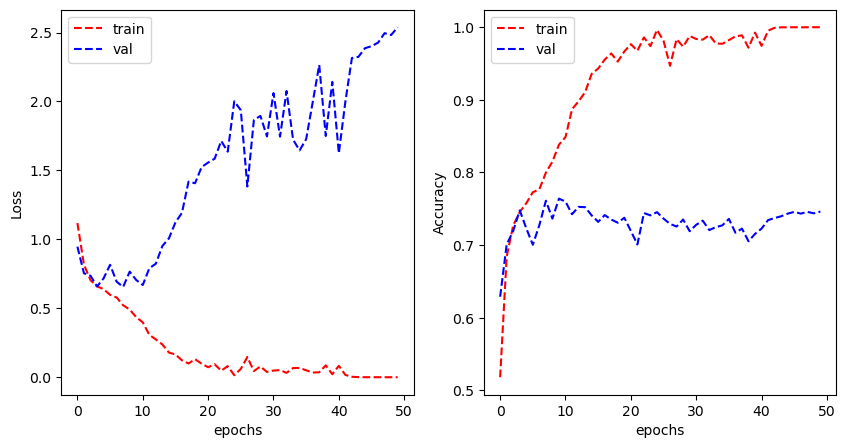

In [17]:
plot_learning_curve(noRegModelVG1.history['loss'], noRegModelVG1.history['val_loss'], 
                    noRegModelVG1.history['categorical_accuracy'], noRegModelVG1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [18]:
noRegModel.evaluate(test_generator)

2023-05-16 18:35:29.667604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1980/1980 [==============================] - 15s 7ms/step - loss: 2.6272 - categorical_accuracy: 0.7455


[2.627185821533203, 0.7454545497894287]

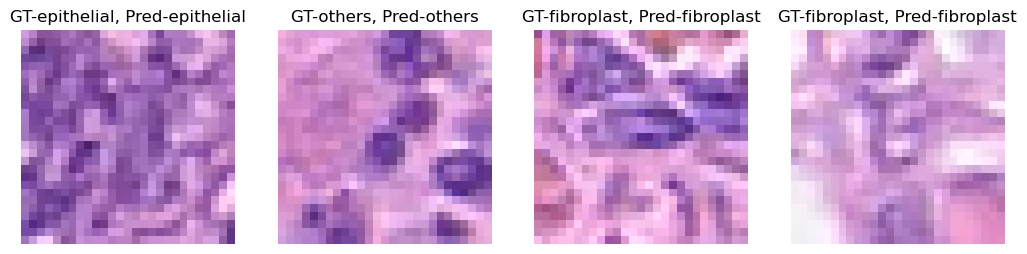

In [19]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = noRegModel.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [20]:
# Define the model architecture
reg_lambda = 0.005 #didnt make a difference, maybe try R1 regularization

cellTypeModel = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(CELL_TYPE_CLASSES, activation='softmax'),
])


In [21]:
cellTypeModel.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

In [22]:
cellTypeModel_VGG_1 = cellTypeModel.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/tmp/ipykernel_27950/240156875.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cellTypeModel_VGG_1 = cellTypeModel.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
2023-05-16 18:35:45.356274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/home/brendon/anaconda3/lib/python3.10/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-05-16 18:35:51.647868: I tensorflow/core/common_runtime/exe

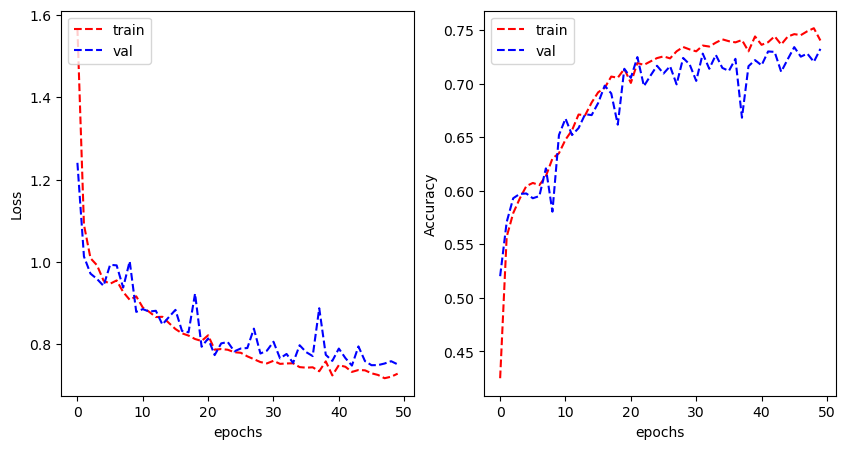

In [23]:
plot_learning_curve(cellTypeModel_VGG_1.history['loss'], cellTypeModel_VGG_1.history['val_loss'], 
                    cellTypeModel_VGG_1.history['categorical_accuracy'], cellTypeModel_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [24]:
cellTypeModel.evaluate(test_generator)

  23/1980 [..............................] - ETA: 14s - loss: 0.6059 - categorical_accuracy: 0.7826

2023-05-16 18:39:13.145045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1980/1980 [==============================] - 17s 8ms/step - loss: 0.7524 - categorical_accuracy: 0.7323


[0.7523865699768066, 0.7323232293128967]

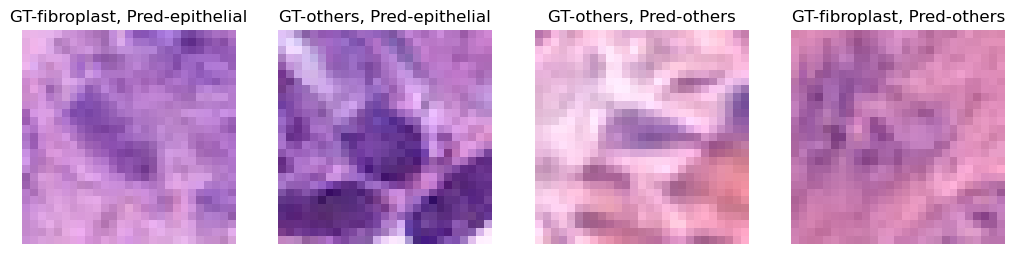

In [25]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = cellTypeModel.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [26]:
pseudoData = ImageDataGenerator(rescale=1./255, data_format='channels_last')
pseudoGen = pseudoData.flow_from_dataframe(
        dataframe=le,
        directory='./patch_images/',
        x_col="ImageName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode=None)

Found 10384 validated image filenames.


In [27]:
predictions = cellTypeModel.predict(pseudoGen)

   33/10384 [..............................] - ETA: 33s 

2023-05-16 18:39:30.610268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10384/10384 [==============================] - 34s 3ms/step


In [28]:
# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Add the predicted labels to the second dataframe
le['cellType'] = predicted_labels

In [29]:
cellTypeModel.evaluate(test_generator)

  15/1980 [..............................] - ETA: 15s - loss: 0.9586 - categorical_accuracy: 0.6000

2023-05-16 18:40:09.601119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1980/1980 [==============================] - 16s 8ms/step - loss: 0.7524 - categorical_accuracy: 0.7323


[0.7523868680000305, 0.7323232293128967]

In [30]:

train_dataHD, val_dataHD = train_test_split(le, test_size=0.2, random_state=42)


train_datagenHD = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagenHD = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27
train_dataHD['cellType'] = train_dataHD['cellType'].astype('str')
val_dataHD['cellType'] = val_dataHD['cellType'].astype('str')

train_generatorHD = train_datagenHD.flow_from_dataframe(
        dataframe=train_dataHD,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generatorHD = val_datagenHD.flow_from_dataframe(
        dataframe=val_dataHD,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 8307 validated image filenames belonging to 4 classes.
Found 2077 validated image filenames belonging to 4 classes.


Lower amount of epochs as the quality of pseudo labels are the best

In [31]:
cellTypeModel_VGG_1 = cellTypeModel.fit(train_generatorHD, validation_data = validation_generatorHD, epochs=20, verbose=0)

2023-05-16 18:40:25.589475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 18:40:29.977565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


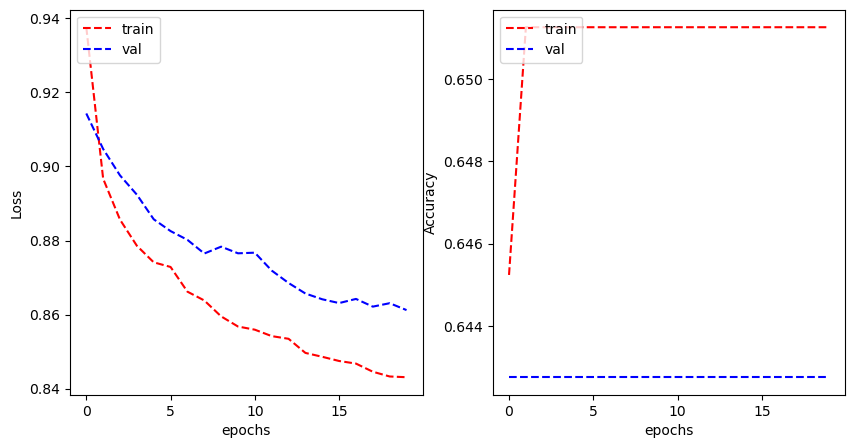

In [32]:
plot_learning_curve(cellTypeModel_VGG_1.history['loss'], cellTypeModel_VGG_1.history['val_loss'], 
                    cellTypeModel_VGG_1.history['categorical_accuracy'], cellTypeModel_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [33]:
cellTypeModel.evaluate(test_generator)

  24/1980 [..............................] - ETA: 13s - loss: 2.3441 - categorical_accuracy: 0.2083   

2023-05-16 18:41:47.903334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1980/1980 [==============================] - 14s 7ms/step - loss: 2.0034 - categorical_accuracy: 0.3995


[2.003401756286621, 0.3994949460029602]

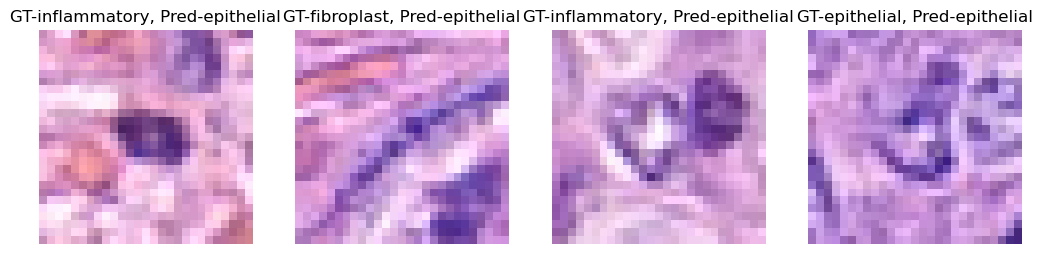

In [34]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = cellTypeModel.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [35]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

In [36]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 7422 validated image filenames belonging to 2 classes.
Found 2474 validated image filenames belonging to 2 classes.


In [37]:
batch_x, batch_y = next(train_generator)
print(batch_x.shape)  # (batch_size, 27, 27, 3)
print(batch_y.shape)  # (batch_size, CELL_TYPE_CLASSES)


(32, 27, 27, 3)
(32, 2)


In [38]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 2 classes.


In [39]:
CANCEROUS_CLASSES = 2

# Define the model architecture
reg_lambda = 0.001

isCancerModel = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(CANCEROUS_CLASSES, activation='softmax'),
])

# IF SOME PART OF THIS FOLLOWING SECTION BREAKS, LOOK AT THE COMMENT IN THE CELL BELOW.

In [40]:
# I HAVE NO IDEA IF THIS WORKS CURRENTLY CAUSE I CANT RUN IT
# BUT IF IT BREAKS, TRY UNCOMMENT THE BELOW CODE AND RUN AGAIN

# METRICS = [
#     tf.keras.metrics.CategoricalAccuracy(),
#     tf.keras.metrics.Recall(),
#     tfa.metrics.F1Score(num_classes=2)
# ]

isCancerModel.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

In [41]:
history_VGG_1 = isCancerModel.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/tmp/ipykernel_27950/473514388.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_VGG_1 = isCancerModel.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
2023-05-16 18:42:02.466195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-16 18:42:07.577567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [42]:
print(history_VGG_1.history.keys())


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


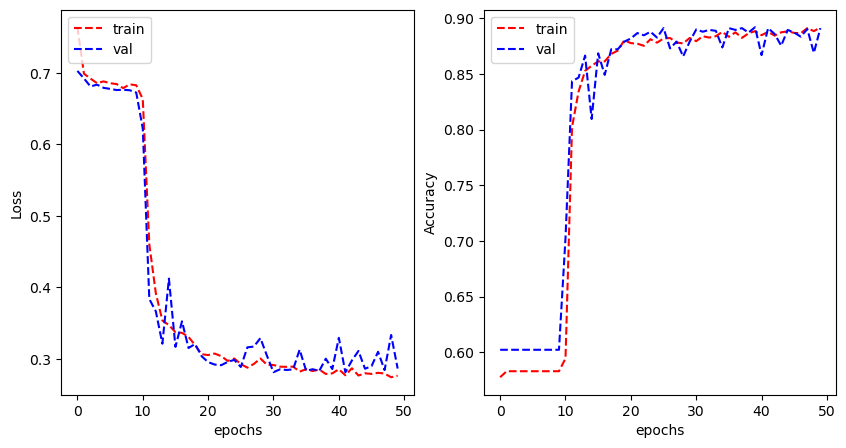

In [43]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [44]:
isCancerModel.evaluate(test_generator)

  23/1980 [..............................] - ETA: 14s - loss: 0.3739 - categorical_accuracy: 0.8696

2023-05-16 18:44:28.288915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1980/1980 [==============================] - 14s 7ms/step - loss: 0.2763 - categorical_accuracy: 0.8965


[0.27632641792297363, 0.8964646458625793]

In [45]:
label_names = {'Not Cancer' : 0, 'Is Cancer' : 1}
lbl = {0: "Not Cancer", 1: "Is Cancer"}

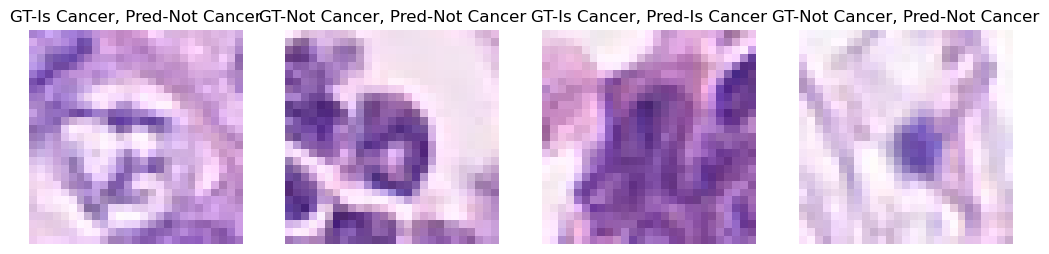

In [46]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = isCancerModel.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])]  ))
            #lbl[int(y_hat[0][0])]
        else:
            break
        
        plt.axis('off')